In [1]:
from GWGen.DressedFluxes.Fluxes import *
import numpy as np
from numpy import array
import scipy as sp
import time
import scipy.optimize as spopt
import scipy.interpolate as spint
import glob
import matplotlib.pyplot as plt
import re
alpha_match_1 = re.compile("Alpha_\d+_\d+")
alpha_match_2 = re.compile("Alpha_\d+")
modeovertonematch = re.compile("Mode_1_Overtone_0")
alpha_rege = re.compile("\d+")
notnan = lambda arr: np.logical_not(np.isnan(arr))
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)
def AlphaValFromFilename(filename):
    alphastr = alpha_match_1.findall(filename)
    if len(alphastr)==0:
        alphastr = alpha_match_2.findall(filename)
    if isinstance(alphastr,str):
        pass
    if isinstance(alphastr,list):
        alphastr=alphastr[0]
    alphapieces = alpha_rege.findall(alphastr)
    if len(alphapieces)>1:
        alphavalue = float(alphapieces[0])/float(alphapieces[1])
    else:
        alphavalue = float(alphapieces[0])
    return alphavalue

In [2]:
testAlphaValue = 0.078
RadialTruncationFactor = 7

starttime = time.time()
#import filenames
allfilenames = glob.glob(pathToSolutionSet+"BHSpin*")
modeovertonebool = [bool(re.search("Mode_1_Overtone_0", i)) for i in allfilenames]
newallfilenames=[]
for inx, boolval in enumerate(modeovertonebool):
    if boolval:
        newallfilenames.append(allfilenames[inx])
allfilenames = newallfilenames

#sort filenames
unsorted_alphavalues = list(map(AlphaValFromFilename, allfilenames))
index_sort = np.argsort(unsorted_alphavalues)
alphavalues = np.array(unsorted_alphavalues)[index_sort]
allfilenames = np.array(allfilenames)[index_sort]


#selected closest neighbors
minList = np.abs(alphavalues - testAlphaValue)
firstNeighbor = np.argmin(minList)
alphavaluesCopy = alphavalues.copy()
alphavaluesCopy[firstNeighbor]=np.inf
secondNeighbor = np.argmin(np.abs(alphavaluesCopy - testAlphaValue))
alphaNeighborsIndex = (min([firstNeighbor, secondNeighbor]), max([firstNeighbor, secondNeighbor]))
selectedfilenames = [allfilenames[i] for i in alphaNeighborsIndex]
selecteddata = [np.load(i) for i in selectedfilenames]
selectedalphas = alphavalues[[alphaNeighborsIndex[0],alphaNeighborsIndex[1]]]

#extract data and generate interpolating function
RadialData = [i["RadialData"] for i in selecteddata]
ThetaData = [i["ThetaData"][0:100] for i in selecteddata]
NewShape = (int(min([len(i) for i in RadialData])/RadialTruncationFactor), 100)
RadialData = [i[:NewShape[0]] for i in RadialData]
ThetaData = [i[:NewShape[1]] for i in ThetaData]

EnData = [i["EnergyData"][:NewShape[0],:NewShape[1] ] for i in selecteddata]
interp = spint.RegularGridInterpolator((selectedalphas, RadialData[0], ThetaData[0]), EnData)
coords = cartesian_product(np.array([testAlphaValue]), RadialData[0], ThetaData[0])
InterpolatedEnergyValues = np.reshape(interp(coords), NewShape)
InterpolationFunction = spint.RectBivariateSpline(RadialData[0], ThetaData[0], InterpolatedEnergyValues)







endtime=time.time()
print(endtime-starttime)


0.04442763328552246


In [252]:
xran = np.arange(RadialData[0][0], RadialData[0][-1], 0.5)
yran = np.arange(0.001, np.pi-0.001, 0.001)
zran = InterpolationFunction(xran,yran)

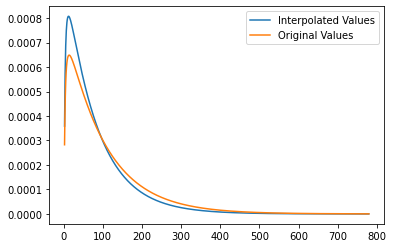

In [258]:
plt.plot(xran, zran[:,1], label="Interpolated Values")
plt.plot(RadialData[0], EnData[0][:, 1], label="Original Values")
plt.legend();